In [7]:
import sys
# Add the path to system, local or mounted S3 bucket, e.g. /dbfs/mnt/<path_to_bucket>
sys.path.append('./secrets.py')

import logging
import math
import os

from influxdb import DataFrameClient
import numpy as np
import matplotlib.mlab as mlab
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from tqdm import tqdm
%matplotlib inline

logging.basicConfig(level=logging.INFO)
LOGGER = logging.getLogger(__name__)

# Need to ssh tunnel for this to work
# ssh -L 8086:localhost:8086 aq.byu.edu -N
influx = DataFrameClient(
    host=HOST,
    port=PORT,
    username=USERNAME,
    password=PASSWORD,
    database=DATABASE,
)


def large_query(influx, measurement, query, total=None, limit=100_000):
    if total is not None:
        total = math.ceil(total / limit)

    with tqdm(total=total) as pbar:
        offset = 0
        while True:
            new_query = query + " LIMIT {} OFFSET {}".format(limit, offset)
            data = influx.query(new_query)
            data = data[measurement]

            received = len(data)
            pbar.update(1)

            yield data

            offset += limit
            if received != limit:
                break


def load_data(filename):
    if os.path.exists(filename):
        LOGGER.info("Loading cached data...")
        return pd.read_hdf(filename)

    LOGGER.info("Downloading data...")
    result = influx.query(
        "SELECT COUNT(sequence) FROM air_quality_sensor WHERE time > '2019-10-01' AND time <= now()"
    )
    count = result["air_quality_sensor"].values[0][0]

    queries = large_query(
        influx,
        "air_quality_sensor",
        "SELECT * FROM air_quality_sensor WHERE time > '2019-10-01' AND time <= now()",
        count,
    )

    all_data = pd.concat(list(queries), sort=False)
    all_data.to_hdf(filename, "data")
    return all_data


data = load_data("aq_data.h5")
gold_data = load_data("aq_data.h5")

LOGGER.info("Done loading data...")



INFO:__main__:Loading cached data...
INFO:__main__:Loading cached data...
INFO:__main__:Done loading data...


2019-11-04 00:00:02+00:00
2019-11-04 08:00:02+08:00
All Sensors names: ['AL', 'AR', 'AZ', 'CA', 'CT', 'DE', 'IA', 'ID', 'IL', 'KS', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'NH', 'NM']
<class 'pandas.core.indexes.base.Index'>
Index(['Monday', 'Monday', 'Monday', 'Monday', 'Monday', 'Monday', 'Monday',
       'Monday', 'Monday', 'Monday'],
      dtype='object')
whiskers:  [1.0, 355.0, 1.0, 433.0, 0.0, 402.0, 2.0, 432.0, 1.0, 420.0, 1.0, 406.0, 0.0, 408.0]
caps:  [1.0, 355.0, 1.0, 433.0, 0.0, 402.0, 2.0, 432.0, 1.0, 420.0, 1.0, 406.0, 0.0, 408.0]
boxes:  [28.0, 26.0, 40.0, 42.0, 33.0, 26.0, 31.0]
medians:  [65.0, 77.0, 85.0, 91.0, 77.0, 69.0, 78.0]
means:  [147.31491505125103, 154.46733330487493, 164.0519893844208, 175.20936136372904, 202.16131789328858, 173.75103693024286, 153.7285464682774]
fliers:  []


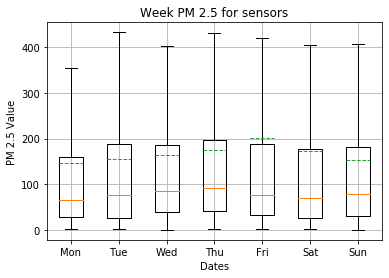

In [8]:
# Day - This is the working boxplot for hybrid only Mongolia deployed sensors
# https://stackoverflow.com/questions/22800079/converting-time-zone-pandas-dataframe
# https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.between_time.html

from IPython.core.debugger import set_trace 
# https://matplotlib.org/3.1.3/gallery/statistics/boxplot_color.html 
data = gold_data
print(data.index[1])
# data = data.tz_convert(None)
# data.index = data.index.tz_localize('GMT')
data.index = data.index.tz_convert('Asia/Ulaanbaatar')
print(data.index[1])

labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.xlabel('Dates')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for sensors')
plt.grid(True)
days = ['05', '06', '07', '08', '09', '10', '11']
data = data[data.pm2_5 >= 0]
data = data[data.location_name == 'Mongolia']
hybrid_modified_gers = ['AL', 'AR', 'AZ', 'CA', 'CT', 'DE', 'IA', 'ID', 'IL', 'KS', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'NH', 'NM']
data = data[(data.name == hybrid_modified_gers[0]) | (data.name == hybrid_modified_gers[1]) | (data.name == hybrid_modified_gers[2]) | (data.name == hybrid_modified_gers[3]) | (data.name == hybrid_modified_gers[4]) | (data.name == hybrid_modified_gers[5]) | (data.name == hybrid_modified_gers[6]) | (data.name == hybrid_modified_gers[7]) | (data.name == hybrid_modified_gers[8]) | (data.name == hybrid_modified_gers[9]) | (data.name == hybrid_modified_gers[10]) | (data.name == hybrid_modified_gers[11]) | (data.name == hybrid_modified_gers[12]) | (data.name == hybrid_modified_gers[13]) | (data.name == hybrid_modified_gers[14]) | (data.name == hybrid_modified_gers[15]) | (data.name == hybrid_modified_gers[16]) | (data.name == hybrid_modified_gers[17]) | (data.name == hybrid_modified_gers[18]) | (data.name == hybrid_modified_gers[19]) | (data.name == hybrid_modified_gers[20])]

all_sensors_names = []
for name, sensor_data in data.groupby("name"):
    all_sensors_names.append(name)
print("All Sensors names:", all_sensors_names)

day_names = data.index.day_name()
print(type(day_names))
print(day_names[:10])

monday = data[(data.index.day_name() == 'Monday')].between_time('15:00:00', '01:00:00')['pm2_5']
tuesday = data[data.index.day_name() == 'Tuesday'].between_time('15:00:00', '01:00:00')['pm2_5']
wednesday = data[data.index.day_name() == 'Wednesday'].between_time('15:00:00', '01:00:00')['pm2_5']
thursday = data[data.index.day_name() == 'Thursday'].between_time('15:00:00', '01:00:00')['pm2_5']
friday = data[data.index.day_name() == 'Friday'].between_time('15:00:00', '01:00:00')['pm2_5']
saturday = data[data.index.day_name() == 'Saturday'].between_time('15:00:00', '01:00:00')['pm2_5']
sunday = data[data.index.day_name() == 'Sunday'].between_time('15:00:00', '01:00:00')['pm2_5']
all_days = [monday, tuesday, wednesday, thursday, friday, saturday, sunday]

results = plt.boxplot(all_days, showfliers=False, labels=labels, showmeans=True, meanline=True)
plt.savefig("./weely_hybrid_day_boxplot_pm_2_5/weely_hybrid_day_boxplot_pm_2_5.png", format='png')

# print(results)
print('whiskers: ', [item.get_ydata()[1] for item in results['whiskers']])
print('caps: ', [item.get_ydata()[1] for item in results['caps']])
print('boxes: ', [item.get_ydata()[1] for item in results['boxes']])
print('medians: ', [item.get_ydata()[1] for item in results['medians']])
print('means: ', [item.get_ydata()[1] for item in results['means']])
print('fliers: ', [item.get_ydata()[1] for item in results['fliers']])

data = gold_data

2019-11-04 08:00:02+08:00
2019-11-04 08:00:02+08:00
All Sensors names: ['AL', 'AR', 'AZ', 'CA', 'CT', 'DE', 'IA', 'ID', 'IL', 'KS', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'NH', 'NM']
<class 'pandas.core.indexes.base.Index'>
Index(['Monday', 'Monday', 'Monday', 'Monday', 'Monday', 'Monday', 'Monday',
       'Monday', 'Monday', 'Monday'],
      dtype='object')
whiskers:  [2.0, 167.0, 178.0, 768.0, 2.0, 267.0, 3.0, 114.0, 7.0, 339.0, 1.0, 190.0, 5.0, 704.0, 185.0, 236.0, 6.0, 339.0, 8.0, 748.0, 9.0, 68.0, 2.0, 267.0, 4.0, 385.0, 5.0, 359.0, 35.0, 169.0, 4.0, 219.0, 2.0, 232.0, 4.0, 484.0, 4.0, 153.0, 6.0, 339.0, 1.0, 118.0]
caps:  [2.0, 167.0, 178.0, 768.0, 2.0, 267.0, 3.0, 114.0, 7.0, 339.0, 1.0, 190.0, 5.0, 704.0, 185.0, 236.0, 6.0, 339.0, 8.0, 748.0, 9.0, 68.0, 2.0, 267.0, 4.0, 385.0, 5.0, 359.0, 35.0, 169.0, 4.0, 219.0, 2.0, 232.0, 4.0, 484.0, 4.0, 153.0, 6.0, 339.0, 1.0, 118.0]
boxes:  [17.0, 398.0, 40.0, 14.0, 24.0, 25.0, 59.0, 191.0, 37.0, 83.0, 23.0, 22.0, 35.0, 40.

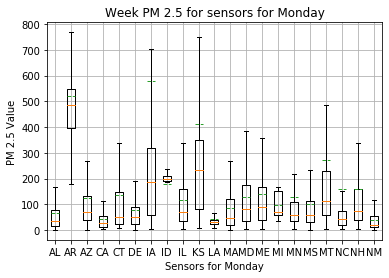

whiskers:  [4.0, 257.0, 4.0, 929.0, 2.0, 387.0, 1.0, 151.0, 4.0, 264.0, 2.0, 229.0, 13.0, 556.0, 67.0, 403.0, 4.0, 517.0, 25.0, 792.0, 4.0, 23.0, 2.0, 318.0, 2.0, 414.0, 5.0, 508.0, 10.0, 280.0, 4.0, 278.0, 3.0, 323.0, 4.0, 422.0, 3.0, 151.0, 6.0, 475.0, 1.0, 131.0]
caps:  [4.0, 257.0, 4.0, 929.0, 2.0, 387.0, 1.0, 151.0, 4.0, 264.0, 2.0, 229.0, 13.0, 556.0, 67.0, 403.0, 4.0, 517.0, 25.0, 792.0, 4.0, 23.0, 2.0, 318.0, 2.0, 414.0, 5.0, 508.0, 10.0, 280.0, 4.0, 278.0, 3.0, 323.0, 4.0, 422.0, 3.0, 151.0, 6.0, 475.0, 1.0, 131.0]
boxes:  [12.0, 272.0, 27.0, 11.0, 24.0, 22.0, 41.0, 193.0, 32.0, 241.0, 8.0, 23.0, 59.0, 33.0, 52.0, 42.0, 31.0, 40.0, 16.0, 63.0, 9.0]
medians:  [52.0, 477.0, 82.0, 28.0, 64.0, 47.0, 137.0, 203.0, 132.0, 348.0, 10.0, 51.0, 122.0, 87.0, 102.0, 87.0, 69.0, 101.0, 30.0, 112.0, 18.0]
means:  [80.77147181233447, 468.27852954442943, 108.8067335243553, 49.40110932710553, 124.08580425085279, 77.4850240180842, 205.80268784361638, 252.26924677486474, 142.49273959341724, 1048

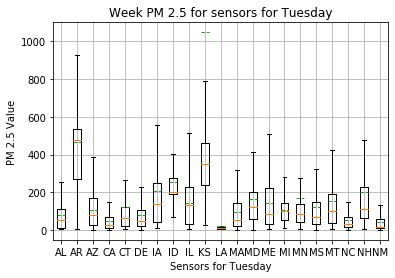

whiskers:  [5.0, 174.0, 104.0, 864.0, 3.0, 295.0, 2.0, 143.0, 4.0, 259.0, 4.0, 236.0, 9.0, 452.0, 185.0, 253.0, 7.0, 506.0, 17.0, 1092.0, 3.0, 232.0, 1.0, 237.0, 2.0, 438.0, 6.0, 467.0, 19.0, 293.0, 5.0, 313.0, 0.0, 344.0, 3.0, 403.0, 4.0, 169.0, 12.0, 286.0, 1.0, 141.0]
caps:  [5.0, 174.0, 104.0, 864.0, 3.0, 295.0, 2.0, 143.0, 4.0, 259.0, 4.0, 236.0, 9.0, 452.0, 185.0, 253.0, 7.0, 506.0, 17.0, 1092.0, 3.0, 232.0, 1.0, 237.0, 2.0, 438.0, 6.0, 467.0, 19.0, 293.0, 5.0, 313.0, 0.0, 344.0, 3.0, 403.0, 4.0, 169.0, 12.0, 286.0, 1.0, 141.0]
boxes:  [22.0, 389.0, 48.0, 16.0, 39.0, 39.0, 51.0, 193.0, 59.0, 56.0, 37.0, 35.0, 62.0, 57.0, 67.25, 38.0, 44.0, 42.0, 31.0, 56.0, 11.0]
medians:  [47.0, 503.0, 89.0, 41.0, 72.0, 80.0, 120.0, 207.0, 135.0, 285.0, 70.5, 65.0, 123.0, 114.0, 131.0, 81.0, 95.0, 99.0, 61.0, 92.0, 34.0]
means:  [71.87777777777778, 608.7253317945759, 105.55540030739137, 52.92111923509561, 135.10233496684924, 107.11672498250525, 274.9950273495773, 212.692714989958, 181.5069625761

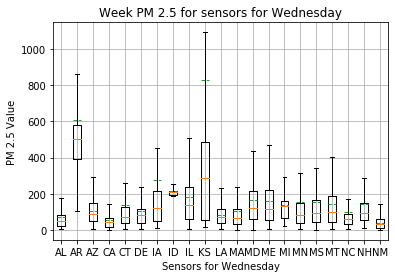

whiskers:  [4.0, 212.0, 206.0, 902.0, 2.0, 302.0, 3.0, 151.0, 10.0, 290.0, 5.0, 225.0, 2.0, 504.0, 160.0, 259.0, 8.0, 525.0, 18.0, 917.0, 11.0, 171.0, 6.0, 275.0, 3.0, 411.0, 10.0, 562.0, 72.0, 2013.0, 3.0, 396.0, 5.0, 309.0, 5.0, 311.0, 8.0, 148.0, 6.0, 921.0, 3.0, 161.0]
caps:  [4.0, 212.0, 206.0, 902.0, 2.0, 302.0, 3.0, 151.0, 10.0, 290.0, 5.0, 225.0, 2.0, 504.0, 160.0, 259.0, 8.0, 525.0, 18.0, 917.0, 11.0, 171.0, 6.0, 275.0, 3.0, 411.0, 10.0, 562.0, 72.0, 2013.0, 3.0, 396.0, 5.0, 309.0, 5.0, 311.0, 8.0, 148.0, 6.0, 921.0, 3.0, 161.0]
boxes:  [25.0, 455.0, 50.0, 19.0, 45.0, 41.5, 30.0, 197.0, 61.0, 348.0, 41.0, 35.0, 57.0, 68.0, 208.0, 36.0, 62.0, 40.0, 36.0, 38.0, 24.0]
medians:  [47.0, 521.0, 85.0, 39.0, 86.0, 74.0, 67.0, 205.0, 119.0, 400.0, 66.0, 69.0, 118.0, 140.0, 322.0, 110.0, 97.5, 92.0, 59.0, 84.5, 44.0]
means:  [65.79296740994855, 588.7339186223197, 106.2897964873153, 58.9476097832129, 169.01648009950247, 87.58271362424583, 152.66320415501397, 223.6024119087997, 174.032378

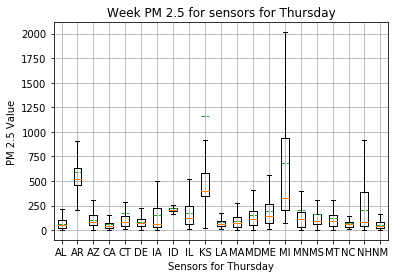

whiskers:  [3.0, 196.0, 259.0, 771.0, 3.0, 308.0, 1.0, 151.0, 7.0, 323.0, 8.0, 225.0, 7.0, 448.0, 51.0, 450.0, 5.0, 441.0, 28.0, 1230.0, 3.0, 161.0, 4.0, 289.0, 5.0, 469.0, 5.0, 469.0, 101.0, 324.0, 2.0, 298.0, 5.0, 237.0, 2.0, 381.0, 9.0, 140.0, 9.0, 702.0, 4.0, 96.0]
caps:  [3.0, 196.0, 259.0, 771.0, 3.0, 308.0, 1.0, 151.0, 7.0, 323.0, 8.0, 225.0, 7.0, 448.0, 51.0, 450.0, 5.0, 441.0, 28.0, 1230.0, 3.0, 161.0, 4.0, 289.0, 5.0, 469.0, 5.0, 469.0, 101.0, 324.0, 2.0, 298.0, 5.0, 237.0, 2.0, 381.0, 9.0, 140.0, 9.0, 702.0, 4.0, 96.0]
boxes:  [19.0, 451.0, 36.0, 14.0, 37.0, 28.0, 53.0, 193.0, 35.0, 82.0, 30.0, 22.0, 52.0, 47.0, 156.0, 31.0, 32.0, 39.0, 28.0, 57.0, 16.0]
medians:  [41.0, 504.0, 72.0, 37.0, 66.0, 57.0, 100.0, 210.0, 73.0, 334.0, 51.0, 54.0, 113.0, 116.0, 189.0, 73.0, 63.0, 88.0, 39.0, 143.0, 26.0]
means:  [60.07802197802198, 510.3261488409923, 96.19867748722572, 52.102387028974626, 117.77574243685817, 90.64170960897242, 282.28458333333333, 286.48496176720477, 160.562607573149

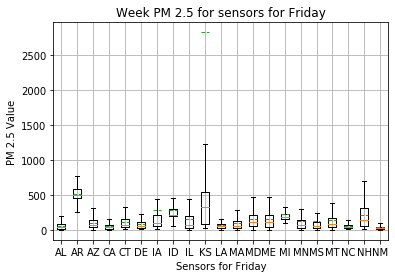

whiskers:  [2.0, 205.0, 322.0, 701.0, 3.0, 318.0, 1.0, 130.0, 7.0, 222.0, 4.0, 245.0, 7.0, 260.0, 131.0, 321.0, 6.0, 474.0, 8.0, 659.0, 2.0, 157.0, 3.0, 272.0, 2.0, 503.0, 4.0, 572.0, 52.0, 825.0, 3.0, 357.0, 3.0, 328.0, 2.0, 366.0, 2.0, 162.0, 8.0, 339.0, 2.0, 114.0]
caps:  [2.0, 205.0, 322.0, 701.0, 3.0, 318.0, 1.0, 130.0, 7.0, 222.0, 4.0, 245.0, 7.0, 260.0, 131.0, 321.0, 6.0, 474.0, 8.0, 659.0, 2.0, 157.0, 3.0, 272.0, 2.0, 503.0, 4.0, 572.0, 52.0, 825.0, 3.0, 357.0, 3.0, 328.0, 2.0, 366.0, 2.0, 162.0, 8.0, 339.0, 2.0, 114.0]
boxes:  [13.0, 464.0, 35.0, 15.0, 32.0, 23.0, 19.0, 194.0, 32.0, 39.0, 19.0, 19.0, 51.0, 35.0, 145.0, 34.0, 30.0, 24.0, 17.0, 43.0, 7.0]
medians:  [40.0, 498.0, 69.0, 34.0, 66.0, 55.0, 40.0, 206.0, 76.0, 90.0, 35.0, 59.0, 131.0, 96.5, 227.0, 62.0, 74.0, 64.0, 36.0, 70.0, 17.0]
means:  [78.98065047344586, 500.1540999057493, 96.47619047619048, 44.73439393939394, 113.54614733276884, 127.40546314665039, 102.54032258064517, 230.41408570216376, 126.94165863066539, 164

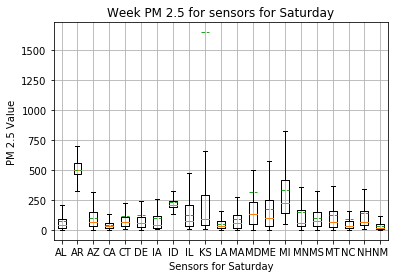

whiskers:  [1.0, 229.0, 205.0, 872.0, 2.0, 269.0, 1.0, 154.0, 7.0, 212.0, 4.0, 198.0, 4.0, 653.0, 1.0, 446.0, 5.0, 491.0, 0.0, 340.0, 5.0, 127.0, 1.0, 234.0, 1.0, 512.0, 3.0, 504.0, 44.0, 521.0, 3.0, 299.0, 3.0, 378.0, 2.0, 548.0, 2.0, 203.0, 8.0, 310.0, 2.0, 113.0]
caps:  [1.0, 229.0, 205.0, 872.0, 2.0, 269.0, 1.0, 154.0, 7.0, 212.0, 4.0, 198.0, 4.0, 653.0, 1.0, 446.0, 5.0, 491.0, 0.0, 340.0, 5.0, 127.0, 1.0, 234.0, 1.0, 512.0, 3.0, 504.0, 44.0, 521.0, 3.0, 299.0, 3.0, 378.0, 2.0, 548.0, 2.0, 203.0, 8.0, 310.0, 2.0, 113.0]
boxes:  [17.0, 455.0, 37.0, 14.0, 25.0, 28.0, 62.0, 144.0, 42.0, 84.0, 22.0, 22.0, 52.0, 56.0, 183.0, 32.0, 28.0, 58.0, 26.0, 43.0, 11.0]
medians:  [42.0, 503.0, 67.0, 35.0, 50.0, 59.0, 131.0, 202.0, 103.0, 125.0, 31.0, 44.0, 116.0, 118.0, 211.5, 73.0, 78.0, 130.0, 56.0, 94.0, 26.0]
means:  [78.55414012738854, 584.9204383039543, 101.16313462418051, 59.58181818181818, 85.96791907514451, 76.80921351719958, 315.5638936535163, 247.36636442141622, 142.92913742359067, 415

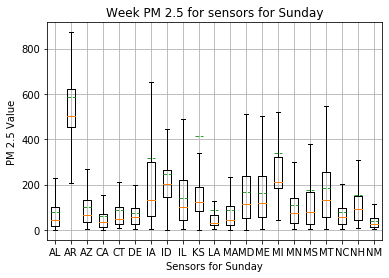

In [10]:
# Day each sensors - This is the working boxplot for hybrid only Mongolia deployed sensors
# https://stackoverflow.com/questions/22800079/converting-time-zone-pandas-dataframe
# https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.between_time.html
import numpy as np
from IPython.core.debugger import set_trace 
# https://matplotlib.org/3.1.3/gallery/statistics/boxplot_color.html 
data = gold_data
print(data.index[1])
# data = data.tz_convert(None)
# data.index = data.index.tz_localize('GMT')
data.index = data.index.tz_convert('Asia/Ulaanbaatar')
print(data.index[1])

labels = ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'IA', 'KS', 'KY', 'LA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'NH']
plt.xlabel('Sensors')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for sensors')
plt.grid(True)
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data = data[data.pm2_5 >= 0]
data = data[data.location_name == 'Mongolia']
hybrid_modified_gers = ['AL', 'AR', 'AZ', 'CA', 'CT', 'DE', 'IA', 'ID', 'IL', 'KS', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'NH', 'NM']
data = data[(data.name == hybrid_modified_gers[0]) | (data.name == hybrid_modified_gers[1]) | (data.name == hybrid_modified_gers[2]) | (data.name == hybrid_modified_gers[3]) | (data.name == hybrid_modified_gers[4]) | (data.name == hybrid_modified_gers[5]) | (data.name == hybrid_modified_gers[6]) | (data.name == hybrid_modified_gers[7]) | (data.name == hybrid_modified_gers[8]) | (data.name == hybrid_modified_gers[9]) | (data.name == hybrid_modified_gers[10]) | (data.name == hybrid_modified_gers[11]) | (data.name == hybrid_modified_gers[12]) | (data.name == hybrid_modified_gers[13]) | (data.name == hybrid_modified_gers[14]) | (data.name == hybrid_modified_gers[15]) | (data.name == hybrid_modified_gers[16]) | (data.name == hybrid_modified_gers[17]) | (data.name == hybrid_modified_gers[18]) | (data.name == hybrid_modified_gers[19]) | (data.name == hybrid_modified_gers[20])]

all_sensors_names = []
for name, sensor_data in data.groupby("name"):
    all_sensors_names.append(name)
print("All Sensors names:", all_sensors_names)

day_names = data.index.day_name()
print(type(day_names))
print(day_names[:10])


# for name, sensor_data in data.groupby("name"):
for day in days_of_week:
    plt.xlabel('Sensors for {0}'.format(day))
    plt.ylabel('PM 2.5 Value')
    plt.title('Week PM 2.5 for sensors for {0}'.format(day))
    plt.grid(True)
    sensors_data = list()
    sensors_name = list()
    temp = data[data.index.day_name() == day]
    # temp = temp.groupby("name")
    for name, sensor_data in temp.groupby("name"):
        sensors_name.append(name)
        sensors_data.append(temp.groupby("name").get_group(name)["pm2_5"].between_time('15:00:00', '01:00:00').to_numpy().tolist())

    results = plt.boxplot(sensors_data, showfliers=False, labels=sensors_name, showmeans=True, meanline=True)
    print('whiskers: ', [item.get_ydata()[1] for item in results['whiskers']])
    print('caps: ', [item.get_ydata()[1] for item in results['caps']])
    print('boxes: ', [item.get_ydata()[1] for item in results['boxes']])
    print('medians: ', [item.get_ydata()[1] for item in results['medians']])
    print('means: ', [item.get_ydata()[1] for item in results['means']])
    print('fliers: ', [item.get_ydata()[1] for item in results['fliers']])
    plt.show()

# monday = data[(data.index.day_name() == 'Monday')]
# monday = monday['AK'].between_time('15:00:00', '01:00:00')['pm2_5']

# tuesday = data[data.index.day_name() == 'Tuesday'].between_time('15:00:00', '01:00:00')['pm2_5']
# wednesday = data[data.index.day_name() == 'Wednesday'].between_time('15:00:00', '01:00:00')['pm2_5']
# thursday = data[data.index.day_name() == 'Thursday'].between_time('15:00:00', '01:00:00')['pm2_5']
# friday = data[data.index.day_name() == 'Friday'].between_time('15:00:00', '01:00:00')['pm2_5']
# saturday = data[data.index.day_name() == 'Saturday'].between_time('15:00:00', '01:00:00')['pm2_5']
# sunday = data[data.index.day_name() == 'Sunday'].between_time('15:00:00', '01:00:00')['pm2_5']
# all_days = [monday, tuesday, wednesday, thursday, friday, saturday, sunday]

# results = plt.boxplot(all_days, showfliers=False, labels=labels, showmeans=True, meanline=True)
# plt.savefig("./weely_hybrid_day_boxplot_pm_2_5/weely_hybrid_day_boxplot_pm_2_5.png", format='png')

# print(results)
# print('whiskers: ', [item.get_ydata()[1] for item in results['whiskers']])
# print('caps: ', [item.get_ydata()[1] for item in results['caps']])
# print('boxes: ', [item.get_ydata()[1] for item in results['boxes']])
# print('medians: ', [item.get_ydata()[1] for item in results['medians']])
# print('means: ', [item.get_ydata()[1] for item in results['means']])
# print('fliers: ', [item.get_ydata()[1] for item in results['fliers']])

data = gold_data

2019-11-04 08:00:02+08:00
2019-11-04 08:00:02+08:00
All Sensors names: ['AL', 'AR', 'AZ', 'CA', 'CT', 'DE', 'IA', 'ID', 'IL', 'KS', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'NH', 'NM']
<class 'pandas.core.indexes.base.Index'>
Index(['Monday', 'Monday', 'Monday', 'Monday', 'Monday', 'Monday', 'Monday',
       'Monday', 'Monday', 'Monday'],
      dtype='object')
whiskers:  [0.0, 169.0, 0.0, 205.0, 0.0, 229.0, 0.0, 170.0, 0.0, 268.0, 0.0, 184.0, 0.0, 206.0]
caps:  [0.0, 169.0, 0.0, 205.0, 0.0, 229.0, 0.0, 170.0, 0.0, 268.0, 0.0, 184.0, 0.0, 206.0]
boxes:  [14.0, 10.0, 17.0, 23.0, 16.0, 9.0, 9.0]
medians:  [35.0, 37.0, 41.0, 43.0, 47.0, 27.0, 37.0]
means:  [85.16154273310111, 92.5591483586394, 98.15781677473964, 96.37837750275384, 111.84969918674608, 80.93567498280498, 111.93612334801762]
fliers:  []


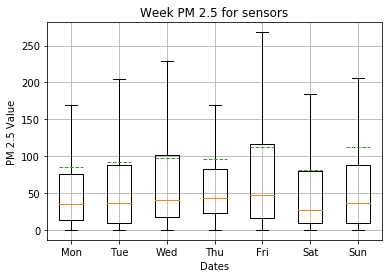

In [12]:
# Night - This is the working boxplot for hybrid only Mongolia deployed sensors
# https://stackoverflow.com/questions/22800079/converting-time-zone-pandas-dataframe
# https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.between_time.html

from IPython.core.debugger import set_trace 
# https://matplotlib.org/3.1.3/gallery/statistics/boxplot_color.html 
data = gold_data
print(data.index[1])
# data = data.tz_convert(None)
# data.index = data.index.tz_localize('GMT')
data.index = data.index.tz_convert('Asia/Ulaanbaatar')
print(data.index[1])

# data.tz_localize('UTC', level=8)

labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.xlabel('Dates')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for sensors')
plt.grid(True)
days = ['05', '06', '07', '08', '09', '10', '11']
data = data[data.pm2_5 >= 0]
data = data[data.location_name == 'Mongolia']
hybrid_modified_gers = ['AL', 'AR', 'AZ', 'CA', 'CT', 'DE', 'IA', 'ID', 'IL', 'KS', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'NH', 'NM']
data = data[(data.name == hybrid_modified_gers[0]) | (data.name == hybrid_modified_gers[1]) | (data.name == hybrid_modified_gers[2]) | (data.name == hybrid_modified_gers[3]) | (data.name == hybrid_modified_gers[4]) | (data.name == hybrid_modified_gers[5]) | (data.name == hybrid_modified_gers[6]) | (data.name == hybrid_modified_gers[7]) | (data.name == hybrid_modified_gers[8]) | (data.name == hybrid_modified_gers[9]) | (data.name == hybrid_modified_gers[10]) | (data.name == hybrid_modified_gers[11]) | (data.name == hybrid_modified_gers[12]) | (data.name == hybrid_modified_gers[13]) | (data.name == hybrid_modified_gers[14]) | (data.name == hybrid_modified_gers[15]) | (data.name == hybrid_modified_gers[16]) | (data.name == hybrid_modified_gers[17]) | (data.name == hybrid_modified_gers[18]) | (data.name == hybrid_modified_gers[19]) | (data.name == hybrid_modified_gers[20])]

all_sensors_names = []
for name, sensor_data in data.groupby("name"):
    all_sensors_names.append(name)
print("All Sensors names:", all_sensors_names)

day_names = data.index.day_name()
print(type(day_names))
print(day_names[:10])

monday = data[(data.index.day_name() == 'Monday')].between_time('01:01', '07:59')['pm2_5']
tuesday = data[data.index.day_name() == 'Tuesday'].between_time('01:01', '07:59')['pm2_5']
wednesday = data[data.index.day_name() == 'Wednesday'].between_time('01:01', '07:59')['pm2_5']
thursday = data[data.index.day_name() == 'Thursday'].between_time('01:01', '07:59')['pm2_5']
friday = data[data.index.day_name() == 'Friday'].between_time('01:01', '07:59')['pm2_5']
saturday = data[data.index.day_name() == 'Saturday'].between_time('01:01', '07:59')['pm2_5']
sunday = data[data.index.day_name() == 'Sunday'].between_time('01:01', '07:59')['pm2_5']
all_days = [monday, tuesday, wednesday, thursday, friday, saturday, sunday]

results = plt.boxplot(all_days, showfliers=False, labels=labels, showmeans=True, meanline=True)
plt.savefig("./weely_hybrid_night_boxplot_pm_2_5/weely_hybrid_night_boxplot_pm_2_5.png", format='png')

# print(results)
print('whiskers: ', [item.get_ydata()[1] for item in results['whiskers']])
print('caps: ', [item.get_ydata()[1] for item in results['caps']])
print('boxes: ', [item.get_ydata()[1] for item in results['boxes']])
print('medians: ', [item.get_ydata()[1] for item in results['medians']])
print('means: ', [item.get_ydata()[1] for item in results['means']])
print('fliers: ', [item.get_ydata()[1] for item in results['fliers']])

data = gold_data

2019-11-04 08:00:02+08:00
2019-11-04 08:00:02+08:00
All Sensors names: ['AL', 'AR', 'AZ', 'CA', 'CT', 'DE', 'IA', 'ID', 'IL', 'KS', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'NH', 'NM']
<class 'pandas.core.indexes.base.Index'>
Index(['Monday', 'Monday', 'Monday', 'Monday', 'Monday', 'Monday', 'Monday',
       'Monday', 'Monday', 'Monday'],
      dtype='object')
whiskers:  [1.0, 100.0, 335.0, 725.0, 2.0, 153.0, 0.0, 49.0, 3.0, 288.0, 2.0, 110.0, 14.0, 276.0, 4.0, 461.0, 13.0, 180.0, 2.0, 66.0, 0.0, 46.0, 1.0, 96.0, 1.0, 138.0, 2.0, 222.0, 34.0, 137.0, 1.0, 127.0, 3.0, 148.0, 2.0, 139.0, 4.0, 85.0, 3.0, 91.0, 5.0, 72.0]
caps:  [1.0, 100.0, 335.0, 725.0, 2.0, 153.0, 0.0, 49.0, 3.0, 288.0, 2.0, 110.0, 14.0, 276.0, 4.0, 461.0, 13.0, 180.0, 2.0, 66.0, 0.0, 46.0, 1.0, 96.0, 1.0, 138.0, 2.0, 222.0, 34.0, 137.0, 1.0, 127.0, 3.0, 148.0, 2.0, 139.0, 4.0, 85.0, 3.0, 91.0, 5.0, 72.0]
boxes:  [13.0, 482.0, 23.0, 7.0, 13.0, 15.0, 49.0, 22.0, 29.0, 5.0, 3.0, 11.0, 18.0, 25.0, 51.25, 20.0, 

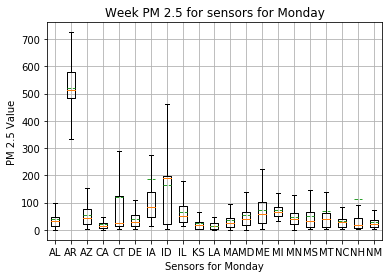

whiskers:  [0.0, 147.0, 393.0, 625.0, 0.0, 190.0, 0.0, 73.0, 3.0, 101.0, 1.0, 128.0, 11.0, 229.0, 179.0, 208.0, 21.0, 185.0, 40.0, 640.0, 1.0, 93.0, 0.0, 165.0, 0.0, 151.0, 0.0, 406.0, 14.0, 73.0, 4.0, 150.0, 0.0, 145.0, 0.0, 192.0, 0.0, 59.0, 3.0, 152.0, 0.0, 57.0]
caps:  [0.0, 147.0, 393.0, 625.0, 0.0, 190.0, 0.0, 73.0, 3.0, 101.0, 1.0, 128.0, 11.0, 229.0, 179.0, 208.0, 21.0, 185.0, 40.0, 640.0, 1.0, 93.0, 0.0, 165.0, 0.0, 151.0, 0.0, 406.0, 14.0, 73.0, 4.0, 150.0, 0.0, 145.0, 0.0, 192.0, 0.0, 59.0, 3.0, 152.0, 0.0, 57.0]
boxes:  [7.0, 478.0, 14.0, 3.0, 14.0, 11.0, 17.0, 186.0, 45.0, 93.0, 4.0, 6.0, 11.0, 14.0, 19.0, 13.0, 11.0, 10.0, 4.0, 12.0, 7.0]
medians:  [32.0, 512.0, 50.0, 15.0, 33.0, 32.0, 74.0, 190.0, 72.0, 226.0, 15.0, 21.0, 43.0, 57.0, 33.0, 37.0, 32.0, 50.0, 12.0, 33.0, 17.0]
means:  [44.876196172248804, 555.3339604891815, 59.62932347182945, 21.494672754946727, 53.712006382130035, 38.39003698063955, 521.3237753882916, 173.48773923444975, 86.4731296101159, 490.382558139534

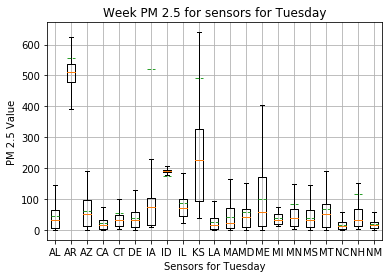

whiskers:  [3.0, 117.0, 280.0, 706.0, 2.0, 146.0, 0.0, 81.0, 1.0, 126.0, 1.0, 123.0, 2.0, 224.0, 177.0, 398.0, 17.0, 459.0, 15.0, 173.0, 4.0, 15.0, 0.0, 173.0, 0.0, 174.0, 1.0, 252.0, 15.0, 80.0, 2.0, 126.0, 1.0, 275.0, 1.0, 209.0, 1.0, 76.0, 4.0, 871.0, 0.0, 72.0]
caps:  [3.0, 117.0, 280.0, 706.0, 2.0, 146.0, 0.0, 81.0, 1.0, 126.0, 1.0, 123.0, 2.0, 224.0, 177.0, 398.0, 17.0, 459.0, 15.0, 173.0, 4.0, 15.0, 0.0, 173.0, 0.0, 174.0, 1.0, 252.0, 15.0, 80.0, 2.0, 126.0, 1.0, 275.0, 1.0, 209.0, 1.0, 76.0, 4.0, 871.0, 0.0, 72.0]
boxes:  [20.0, 442.0, 21.0, 6.0, 11.0, 16.0, 6.0, 191.0, 24.0, 31.0, 7.0, 7.0, 18.0, 30.0, 25.0, 21.0, 20.0, 19.0, 9.0, 24.0, 7.0]
medians:  [35.0, 506.0, 38.0, 19.0, 24.0, 31.0, 31.0, 198.0, 86.0, 46.0, 9.5, 34.0, 45.0, 66.0, 37.0, 36.0, 48.0, 51.0, 21.0, 92.0, 16.0]
means:  [51.10356762513312, 474.5656868626275, 60.710612333841794, 29.205342902711322, 53.554605263157896, 44.321969696969695, 158.78787878787878, 231.7345026429601, 116.90492359932088, 91.18430034129693

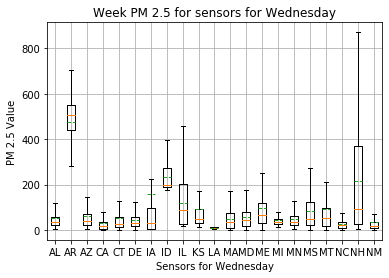

whiskers:  [5.0, 97.0, 320.0, 697.0, 8.0, 149.0, 0.0, 84.0, 9.0, 69.0, 8.0, 106.0, 7.0, 141.0, 183.0, 239.0, 12.0, 57.0, 10.0, 64.0, 7.0, 75.0, 3.0, 135.0, 5.0, 148.0, 13.0, 221.0, 22.0, 189.0, 4.0, 130.0, 11.0, 189.0, 6.0, 118.0, 7.0, 83.0, 4.0, 256.0, 0.0, 70.0]
caps:  [5.0, 97.0, 320.0, 697.0, 8.0, 149.0, 0.0, 84.0, 9.0, 69.0, 8.0, 106.0, 7.0, 141.0, 183.0, 239.0, 12.0, 57.0, 10.0, 64.0, 7.0, 75.0, 3.0, 135.0, 5.0, 148.0, 13.0, 221.0, 22.0, 189.0, 4.0, 130.0, 11.0, 189.0, 6.0, 118.0, 7.0, 83.0, 4.0, 256.0, 0.0, 70.0]
boxes:  [20.0, 483.0, 27.0, 12.0, 23.0, 26.0, 24.0, 189.0, 19.0, 17.0, 14.0, 18.0, 33.0, 41.0, 42.0, 16.0, 33.0, 18.0, 25.0, 15.0, 10.0]
medians:  [35.0, 550.0, 44.0, 21.0, 31.0, 41.0, 36.0, 194.0, 28.0, 26.0, 32.0, 40.0, 51.0, 69.0, 61.0, 31.0, 60.0, 33.0, 41.0, 48.0, 20.0]
means:  [41.133352617876774, 504.62785752259435, 57.35412605588044, 28.031287365484257, 38.27368421052632, 43.118505195843326, 63.06507936507936, 184.90386151797603, 75.4014466546112, 90.60389610389

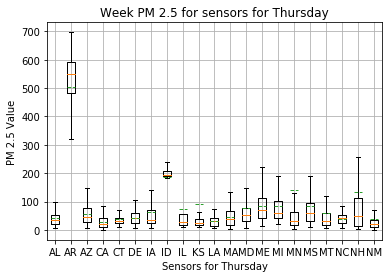

whiskers:  [1.0, 149.0, 398.0, 662.0, 3.0, 235.0, 0.0, 100.0, 2.0, 91.0, 2.0, 134.0, 3.0, 353.0, 179.0, 218.0, 57.0, 110.0, 203.0, 563.0, 1.0, 74.0, 1.0, 176.0, 2.0, 203.0, 1.0, 417.0, 76.0, 175.0, 2.0, 203.0, 3.0, 302.0, 1.0, 114.0, 2.0, 132.0, 2.0, 425.0, 1.0, 92.0]
caps:  [1.0, 149.0, 398.0, 662.0, 3.0, 235.0, 0.0, 100.0, 2.0, 91.0, 2.0, 134.0, 3.0, 353.0, 179.0, 218.0, 57.0, 110.0, 203.0, 563.0, 1.0, 74.0, 1.0, 176.0, 2.0, 203.0, 1.0, 417.0, 76.0, 175.0, 2.0, 203.0, 3.0, 302.0, 1.0, 114.0, 2.0, 132.0, 2.0, 425.0, 1.0, 92.0]
boxes:  [15.0, 497.0, 23.0, 5.0, 16.0, 19.0, 13.0, 186.0, 65.0, 338.0, 12.0, 9.0, 19.0, 27.0, 113.0, 13.0, 15.0, 12.0, 8.0, 20.0, 7.0]
medians:  [49.0, 521.0, 51.0, 20.0, 29.0, 37.0, 47.5, 192.0, 72.0, 366.0, 24.5, 37.0, 50.0, 95.0, 129.0, 46.0, 44.0, 28.0, 28.0, 81.0, 18.0]
means:  [49.1311004784689, 530.0493058879847, 68.87300637958533, 30.249300838993207, 34.80342902711324, 44.68637634838194, 98.86662679425838, 173.06986382474838, 77.72941176470589, 899.97061

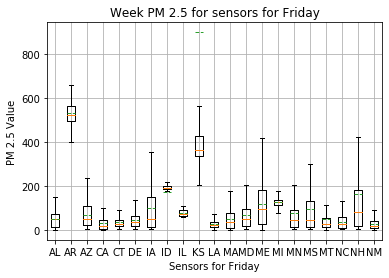

whiskers:  [0.0, 102.0, 384.0, 690.0, 2.0, 147.0, 0.0, 64.0, 0.0, 101.0, 1.0, 110.0, 4.0, 97.0, 176.0, 227.0, 5.0, 100.0, 12.0, 271.0, 0.0, 91.0, 0.0, 127.0, 1.0, 177.0, 1.0, 208.0, 24.0, 168.0, 2.0, 66.0, 2.0, 97.0, 1.0, 110.0, 1.0, 92.0, 6.0, 410.0, 1.0, 28.0]
caps:  [0.0, 102.0, 384.0, 690.0, 2.0, 147.0, 0.0, 64.0, 0.0, 101.0, 1.0, 110.0, 4.0, 97.0, 176.0, 227.0, 5.0, 100.0, 12.0, 271.0, 0.0, 91.0, 0.0, 127.0, 1.0, 177.0, 1.0, 208.0, 24.0, 168.0, 2.0, 66.0, 2.0, 97.0, 1.0, 110.0, 1.0, 92.0, 6.0, 410.0, 1.0, 28.0]
boxes:  [12.0, 498.0, 12.0, 4.0, 6.0, 10.0, 22.0, 180.0, 20.0, 30.0, 4.0, 5.0, 15.0, 14.0, 33.0, 9.0, 7.0, 7.0, 5.0, 12.0, 3.0]
medians:  [25.0, 520.0, 30.0, 10.0, 13.0, 21.0, 37.0, 190.0, 30.0, 40.0, 10.0, 20.0, 37.0, 44.0, 45.0, 19.0, 24.0, 18.0, 20.0, 31.0, 8.0]
means:  [43.058745348219034, 534.7230861244019, 45.31853785900783, 30.810569812962157, 41.288392500997205, 37.60100130605137, 49.39892344497608, 163.7061435973353, 46.09077269317329, 181.9434546862897, 26.6222760

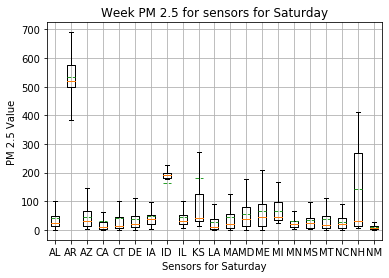

whiskers:  [0.0, 126.0, 384.0, 683.0, 0.0, 158.0, 0.0, 99.0, 1.0, 162.0, 1.0, 119.0, 1.0, 301.0, 176.0, 245.0, 14.0, 148.0, 16.0, 152.0, 1.0, 136.0, 0.0, 200.0, 0.0, 174.0, 0.0, 233.0, 38.0, 246.0, 3.0, 139.0, 1.0, 206.0, 0.0, 174.0, 0.0, 96.0, 3.0, 205.0, 0.0, 124.0]
caps:  [0.0, 126.0, 384.0, 683.0, 0.0, 158.0, 0.0, 99.0, 1.0, 162.0, 1.0, 119.0, 1.0, 301.0, 176.0, 245.0, 14.0, 148.0, 16.0, 152.0, 1.0, 136.0, 0.0, 200.0, 0.0, 174.0, 0.0, 233.0, 38.0, 246.0, 3.0, 139.0, 1.0, 206.0, 0.0, 174.0, 0.0, 96.0, 3.0, 205.0, 0.0, 124.0]
boxes:  [16.0, 481.0, 10.0, 4.0, 5.0, 9.0, 5.0, 190.0, 22.0, 27.0, 4.0, 5.0, 7.0, 13.0, 66.25, 17.0, 9.0, 19.0, 5.0, 10.0, 2.0]
medians:  [30.0, 522.5, 44.0, 10.0, 28.0, 23.0, 39.0, 201.0, 40.0, 40.0, 7.0, 20.0, 24.0, 53.0, 100.0, 43.0, 35.0, 47.0, 14.0, 29.0, 21.0]
means:  [39.70753588516747, 483.4131920710868, 47.262491203377905, 29.568725532840364, 64.69964100518548, 62.87578855775506, 68.68102073365232, 213.8133971291866, 56.127450980392155, 1844.64984227129

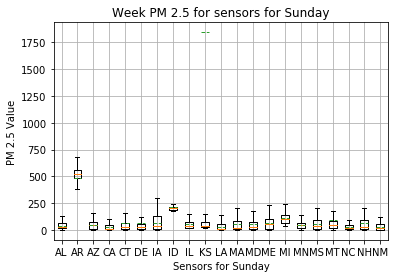

In [13]:
# Night each sensors - This is the working boxplot for hybrid only Mongolia deployed sensors
# https://stackoverflow.com/questions/22800079/converting-time-zone-pandas-dataframe
# https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.between_time.html

from IPython.core.debugger import set_trace 
# https://matplotlib.org/3.1.3/gallery/statistics/boxplot_color.html 
data = gold_data
print(data.index[1])
# data = data.tz_convert(None)
# data.index = data.index.tz_localize('GMT')
data.index = data.index.tz_convert('Asia/Ulaanbaatar')
print(data.index[1])

# data.tz_localize('UTC', level=8)

labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.xlabel('Dates')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for sensors')
plt.grid(True)
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data = data[data.pm2_5 >= 0]
data = data[data.location_name == 'Mongolia']
hybrid_modified_gers = ['AL', 'AR', 'AZ', 'CA', 'CT', 'DE', 'IA', 'ID', 'IL', 'KS', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'NH', 'NM']
data = data[(data.name == hybrid_modified_gers[0]) | (data.name == hybrid_modified_gers[1]) | (data.name == hybrid_modified_gers[2]) | (data.name == hybrid_modified_gers[3]) | (data.name == hybrid_modified_gers[4]) | (data.name == hybrid_modified_gers[5]) | (data.name == hybrid_modified_gers[6]) | (data.name == hybrid_modified_gers[7]) | (data.name == hybrid_modified_gers[8]) | (data.name == hybrid_modified_gers[9]) | (data.name == hybrid_modified_gers[10]) | (data.name == hybrid_modified_gers[11]) | (data.name == hybrid_modified_gers[12]) | (data.name == hybrid_modified_gers[13]) | (data.name == hybrid_modified_gers[14]) | (data.name == hybrid_modified_gers[15]) | (data.name == hybrid_modified_gers[16]) | (data.name == hybrid_modified_gers[17]) | (data.name == hybrid_modified_gers[18]) | (data.name == hybrid_modified_gers[19]) | (data.name == hybrid_modified_gers[20])]

all_sensors_names = []
for name, sensor_data in data.groupby("name"):
    all_sensors_names.append(name)
print("All Sensors names:", all_sensors_names)

day_names = data.index.day_name()
print(type(day_names))
print(day_names[:10])

for day in days_of_week:
    plt.xlabel('Sensors for {0}'.format(day))
    plt.ylabel('PM 2.5 Value')
    plt.title('Week PM 2.5 for sensors for {0}'.format(day))
    plt.grid(True)
    sensors_data = list()
    sensors_name = list()
    temp = data[data.index.day_name() == day]
    # temp = temp.groupby("name")
    for name, sensor_data in temp.groupby("name"):
        sensors_name.append(name)
        sensors_data.append(temp.groupby("name").get_group(name)["pm2_5"].between_time('01:01', '07:59').to_numpy().tolist())

    results = plt.boxplot(sensors_data, showfliers=False, labels=sensors_name, showmeans=True, meanline=True)
    print('whiskers: ', [item.get_ydata()[1] for item in results['whiskers']])
    print('caps: ', [item.get_ydata()[1] for item in results['caps']])
    print('boxes: ', [item.get_ydata()[1] for item in results['boxes']])
    print('medians: ', [item.get_ydata()[1] for item in results['medians']])
    print('means: ', [item.get_ydata()[1] for item in results['means']])
    print('fliers: ', [item.get_ydata()[1] for item in results['fliers']])
    plt.show()


# monday = data[(data.index.day_name() == 'Monday')].between_time('01:01', '07:59')['pm2_5']
# tuesday = data[data.index.day_name() == 'Tuesday'].between_time('01:01', '07:59')['pm2_5']
# wednesday = data[data.index.day_name() == 'Wednesday'].between_time('01:01', '07:59')['pm2_5']
# thursday = data[data.index.day_name() == 'Thursday'].between_time('01:01', '07:59')['pm2_5']
# friday = data[data.index.day_name() == 'Friday'].between_time('01:01', '07:59')['pm2_5']
# saturday = data[data.index.day_name() == 'Saturday'].between_time('01:01', '07:59')['pm2_5']
# sunday = data[data.index.day_name() == 'Sunday'].between_time('01:01', '07:59')['pm2_5']
# all_days = [monday, tuesday, wednesday, thursday, friday, saturday, sunday]

# results = plt.boxplot(all_days, showfliers=False, labels=labels, showmeans=True, meanline=True)
# plt.savefig("./weely_hybrid_night_boxplot_pm_2_5/weely_hybrid_night_boxplot_pm_2_5.png", format='png')

# # print(results)
# print('whiskers: ', [item.get_ydata()[1] for item in results['whiskers']])
# print('caps: ', [item.get_ydata()[1] for item in results['caps']])
# print('boxes: ', [item.get_ydata()[1] for item in results['boxes']])
# print('medians: ', [item.get_ydata()[1] for item in results['medians']])
# print('means: ', [item.get_ydata()[1] for item in results['means']])
# print('fliers: ', [item.get_ydata()[1] for item in results['fliers']])

data = gold_data